In [2]:
import sys
!{sys.executable} -m pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!{sys.executable} -m pip install scikit-learn

import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Looking in indexes: https://download.pytorch.org/whl/cu118
Using device: cuda


In [22]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import random

# Ensure reproducibility of subsets and data splits
torch.manual_seed(42)
random.seed(42)

# ImageNet statistics for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Transformations for AlexNet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Define paths (using the `path` variable from kernel state)
train_dir = f'{path}/train'
test_dir = f'{path}/test'

# Create full datasets for train and test
full_train_dataset_original = datasets.ImageFolder(train_dir, transform=transform)
full_test_dataset = datasets.ImageFolder(test_dir, transform=transform)

print(f"Original Full Train dataset size: {len(full_train_dataset_original)}")
print(f"Original Full Test dataset size: {len(full_test_dataset)}")

# Split the original training dataset into a new training and validation set
train_ratio = 0.9  # 90% for training, 10% for validation
train_split_size = int(train_ratio * len(full_train_dataset_original))
val_split_size = len(full_train_dataset_original) - train_split_size

# Use random_split to create initial train and val datasets
initial_train_dataset, initial_val_dataset = torch.utils.data.random_split(
    full_train_dataset_original, [train_split_size, val_split_size],
    generator=torch.Generator().manual_seed(42) # For reproducible split
)

print(f"\nInitial Train split size: {len(initial_train_dataset)}")
print(f"Initial Validation split size: {len(initial_val_dataset)}")

# Determine subset sizes based on available memory/compute
# Using fixed smaller subsets for demonstration as recommended for free environments
train_subset_size = min(10000, len(initial_train_dataset)) # Adjust as needed
val_subset_size = min(1000, len(initial_val_dataset))   # Adjust as needed
test_subset_size = min(1000, len(full_test_dataset))   # Adjust as needed

# Create indices for subsets from the initial splits/datasets
train_indices = random.sample(range(len(initial_train_dataset)), train_subset_size)
val_indices = random.sample(range(len(initial_val_dataset)), val_subset_size)
test_indices = random.sample(range(len(full_test_dataset)), test_subset_size)

# Create final subsets using Subset
train_dataset = Subset(initial_train_dataset, train_indices)
val_dataset = Subset(initial_val_dataset, val_indices)
test_dataset = Subset(full_test_dataset, test_indices)

# Create DataLoaders
batch_size = 64
num_workers = 2 # Adjust based on system capabilities and dataset size

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print(f'\nUsing subsets:')
print(f'Train dataset size (subset): {len(train_dataset)}')
print(f'Validation dataset size (subset): {len(val_dataset)}')
print(f'Test dataset size (subset): {len(test_dataset)}')

print(f'Number of batches in train_loader: {len(train_loader)}')
print(f'Number of batches in val_loader: {len(val_loader)}')
print(f'Number of batches in test_loader: {len(test_loader)}')


Original Full Train dataset size: 100000
Original Full Test dataset size: 20000

Initial Train split size: 90000
Initial Validation split size: 10000

Using subsets:
Train dataset size (subset): 10000
Validation dataset size (subset): 1000
Test dataset size (subset): 1000
Number of batches in train_loader: 157
Number of batches in val_loader: 16
Number of batches in test_loader: 16


In [23]:
import torch.nn as nn
from torchvision import models

# Load pre-trained AlexNet model
alexnet_model = models.alexnet(pretrained=True)

# Modify the final classification layer for binary classification
# The original AlexNet has 1000 output classes for ImageNet.
# We need to replace the last linear layer (classifier[6]) to output 2 classes.
num_ftrs = alexnet_model.classifier[6].in_features
alexnet_model.classifier[6] = nn.Linear(num_ftrs, 2) # 2 classes: real/synthetic

# Move the model to the specified device
alexnet_model = alexnet_model.to(device)

print("AlexNet model loaded and adapted for binary classification.")
print(f"Model moved to device: {device}")
print(alexnet_model.classifier)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet model loaded and adapted for binary classification.
Model moved to device: cuda
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)


In [24]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_model.parameters(), lr=0.001)

print("Loss function (CrossEntropyLoss) and Optimizer (Adam) initialized.")

Loss function (CrossEntropyLoss) and Optimizer (Adam) initialized.


In [33]:

import torch.nn.functional as F

num_epochs = 10 # Define the number of training epochs

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Training Phase
    alexnet_model.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation Phase
    alexnet_model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = alexnet_model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], ' +
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, ' +
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

print('Finished Training')



Starting training for 10 epochs...
Epoch [1/10], Train Loss: 0.6934, Train Acc: 50.26%, Val Loss: 0.6939, Val Acc: 48.50%
Epoch [2/10], Train Loss: 0.6933, Train Acc: 50.82%, Val Loss: 0.6928, Val Acc: 51.50%
Epoch [3/10], Train Loss: 0.6933, Train Acc: 49.48%, Val Loss: 0.6941, Val Acc: 48.50%
Epoch [4/10], Train Loss: 0.6934, Train Acc: 50.33%, Val Loss: 0.6927, Val Acc: 51.50%
Epoch [5/10], Train Loss: 0.6935, Train Acc: 50.05%, Val Loss: 0.6932, Val Acc: 48.50%
Epoch [6/10], Train Loss: 0.6933, Train Acc: 50.73%, Val Loss: 0.6934, Val Acc: 48.50%
Epoch [7/10], Train Loss: 0.6932, Train Acc: 50.41%, Val Loss: 0.6933, Val Acc: 48.50%
Epoch [8/10], Train Loss: 0.6933, Train Acc: 50.44%, Val Loss: 0.6929, Val Acc: 51.50%
Epoch [9/10], Train Loss: 0.6934, Train Acc: 50.54%, Val Loss: 0.6951, Val Acc: 48.50%
Epoch [10/10], Train Loss: 0.6936, Train Acc: 49.77%, Val Loss: 0.6936, Val Acc: 48.50%
Finished Training


Starting model evaluation on the test set...

Test Accuracy: 0.5270

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.53      1.00      0.69       527
        REAL       0.00      0.00      0.00       473

    accuracy                           0.53      1000
   macro avg       0.26      0.50      0.35      1000
weighted avg       0.28      0.53      0.36      1000


Confusion Matrix:
[[527   0]
 [473   0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


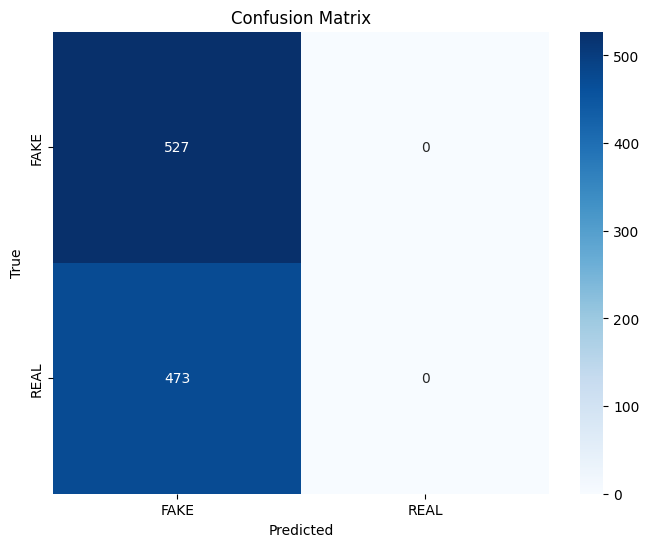

Model evaluation complete.


In [36]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
alexnet_model.eval()

# Lists to store true and predicted labels
all_labels = []
all_predictions = []

print("Starting model evaluation on the test set...")

# No gradient calculation during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = alexnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'\nTest Accuracy: {accuracy:.4f}')

# Generate Classification Report
# Use the classes from the original full dataset for correct labels
# The variable `full_train_dataset_original` is an ImageFolder which has the .classes attribute.
class_names = full_train_dataset_original.classes
report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=False)
print('\nClassification Report:')
print(report)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('\nConfusion Matrix:')
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Model evaluation complete.")


Generating Grad-CAM visualizations for sample images...


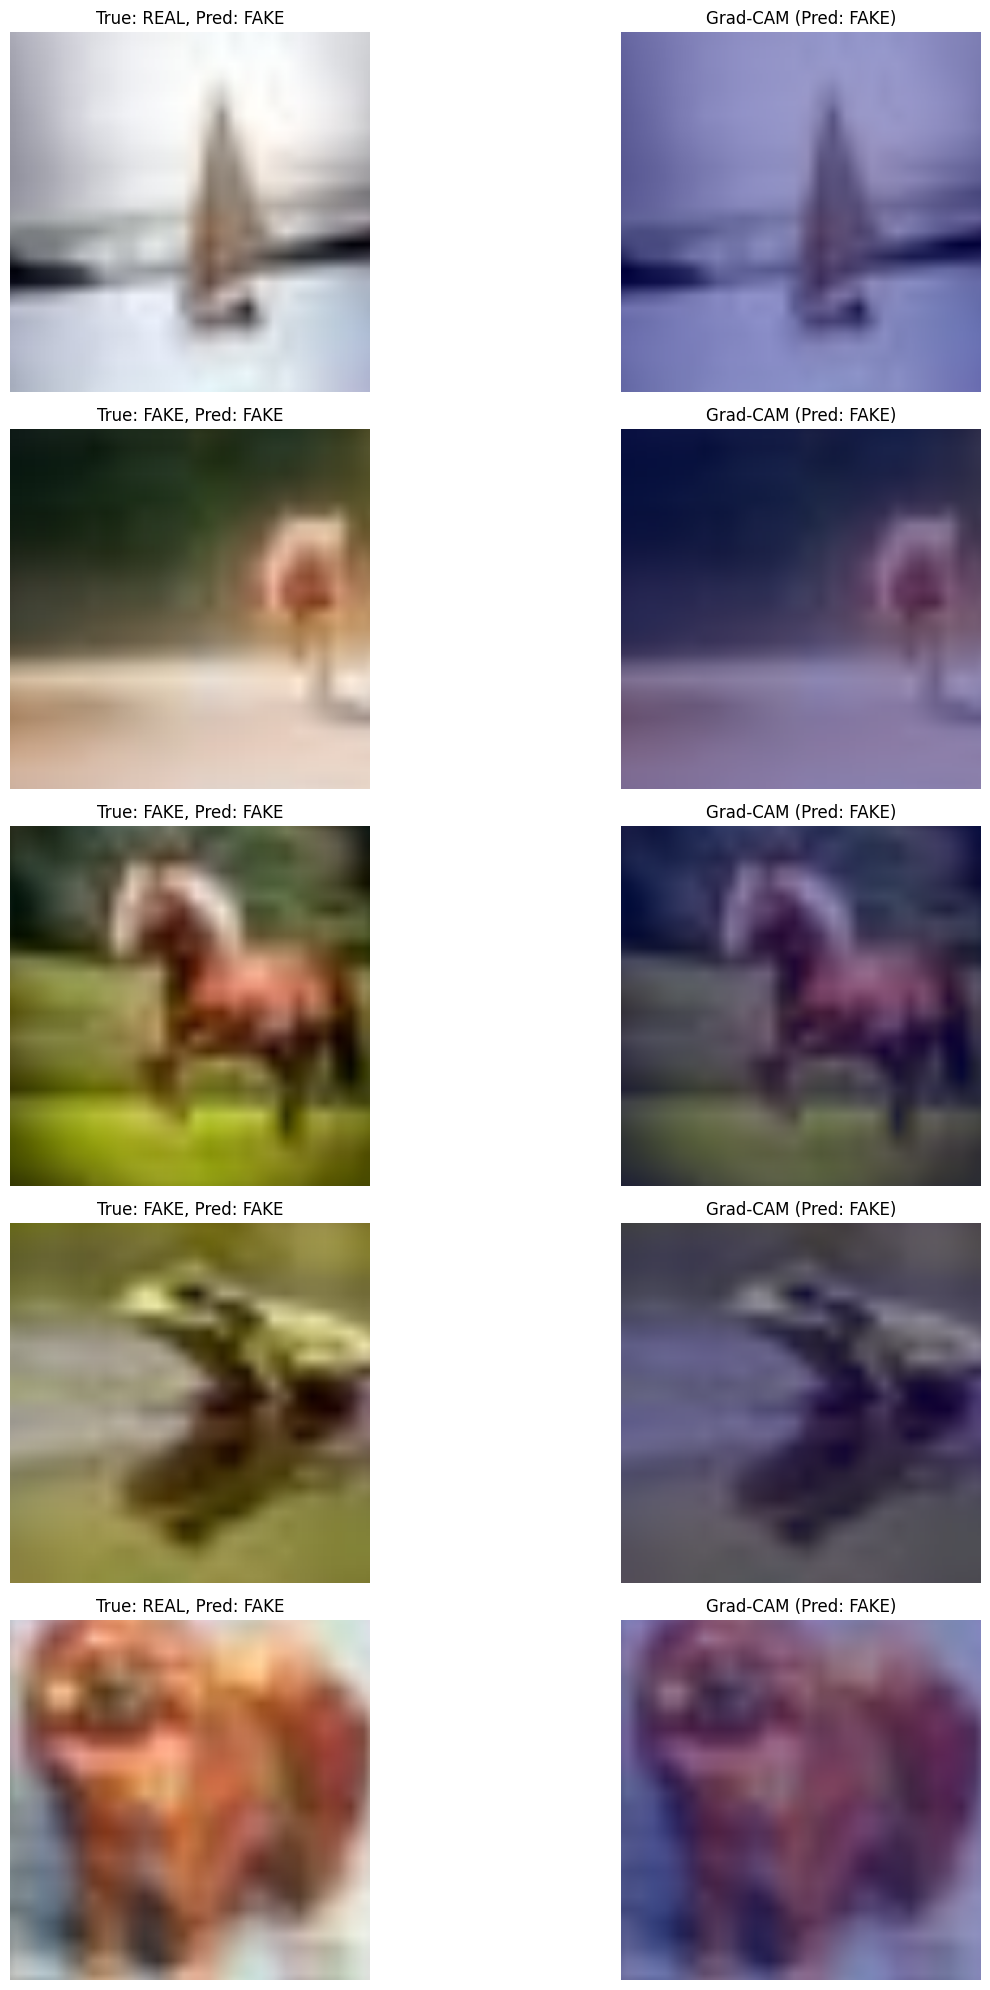

Grad-CAM visualization complete.


In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Ensure the model is in evaluation mode
alexnet_model.eval()

# Modify AlexNet's ReLU layers to be non-in-place
# This is crucial for Grad-CAM to avoid 'RuntimeError: Output 0 of BackwardHookFunctionBackward is a view'
for module in alexnet_model.features.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False

# Store feature maps and gradients
feature_maps = None
gradients = None

def hook_fn_forward(module, input, output):
    global feature_maps
    feature_maps = output.cpu() # Store feature maps

def hook_fn_backward(module, grad_input, grad_output):
    global gradients
    # grad_output is a tuple; the gradient for the output of the module is the first element
    gradients = grad_output[0].cpu() # Store gradients

# Define the target layer for AlexNet (the last convolutional layer is usually a good choice)
target_layer = alexnet_model.features[10] # Example: features block, last Conv2d layer

# Register hooks
forward_hook = target_layer.register_forward_hook(hook_fn_forward)
backward_hook = target_layer.register_full_backward_hook(hook_fn_backward)


def generate_grad_cam(model, input_image, target_class_idx):
    model.zero_grad()

    # Make sure to clone input_image for gradient calculation if it's reused
    input_image_for_grad = input_image.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(input_image_for_grad)

    # If the target_class_idx is None, use the predicted class
    if target_class_idx is None:
        target_class_idx = output.argmax(dim=1).item()

    # Backward pass for the target class
    # Create a one-hot vector for the target class
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0][target_class_idx] = 1
    output.backward(gradient=one_hot_output, retain_graph=True)

    # Get feature maps and gradients from global variables
    global feature_maps, gradients
    if feature_maps is None or gradients is None:
        raise RuntimeError("Feature maps or gradients not captured. Check hooks.")

    # Clone feature_maps to avoid in-place modification error for heatmap calculation
    cloned_feature_maps = feature_maps.clone()

    # Average the gradients across spatial dimensions (GAP)
    # The gradients stored in `gradients` are for the output of the `target_layer`
    # `gradients` has shape (N, C, H, W)
    pooled_gradients = torch.mean(gradients, dim=[2, 3]) # Average gradients for each feature map

    # Weight the channels by their corresponding gradients
    # Multiply each feature map by its corresponding gradient weight
    # Ensure dimensions match for broadcasting
    for i in range(cloned_feature_maps.shape[1]):
        cloned_feature_maps[:, i, :, :] *= pooled_gradients[0, i] # pooled_gradients[0, i] is scalar

    # Average the weighted feature maps to get the CAM
    heatmap = torch.mean(cloned_feature_maps, dim=1).squeeze()

    # Apply ReLU to the heatmap to only get positive contributions
    heatmap = F.relu(heatmap)

    # Normalize the heatmap to 0-1
    max_val = torch.max(heatmap)
    if max_val > 0:
        heatmap /= max_val
    else:
        heatmap = torch.zeros_like(heatmap) # Handle case where all values are zero

    return heatmap.detach().numpy()


def denormalize_image(image_tensor, mean, std):
    # Reverse normalization: img = img * std + mean
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image_tensor = image_tensor.cpu() * std + mean
    # Clip values to [0, 1] range for image display
    image_tensor = torch.clamp(image_tensor, 0, 1)
    return image_tensor.permute(1, 2, 0).numpy() # Convert from C, H, W to H, W, C for matplotlib


print("Generating Grad-CAM visualizations for sample images...")

# Select a few sample images from the test_dataset
sample_indices = random.sample(range(len(test_dataset)), 5) # Get 5 random samples

# Transformations for denormalization (using previously defined mean and std)
# Note: This inv_normalize is not used, denormalize_image function handles it.
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

plt.figure(figsize=(15, len(sample_indices) * 4))

for i, idx in enumerate(sample_indices):
    image_tensor, true_label_idx = test_dataset[idx]
    # Ensure image_tensor requires grad for Grad-CAM calculation
    # input_image_for_grad is used inside generate_grad_cam
    image_tensor_for_grad_cam = image_tensor.unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad(): # Use no_grad for the prediction part as we only need the value
        output = alexnet_model(image_tensor_for_grad_cam)
        predicted_label_idx = output.argmax(dim=1).item()

    # Generate Grad-CAM heatmap for the predicted class
    heatmap = generate_grad_cam(alexnet_model, image_tensor_for_grad_cam, predicted_label_idx)

    # Denormalize the original image for display
    original_image_display = denormalize_image(image_tensor.squeeze(0), mean, std)

    # Resize heatmap to original image size
    h, w = original_image_display.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))

    # Overlay heatmap on original image
    # Convert original image to uint8 for cv2 operations if needed, but here matplotlib handles float [0,1]
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    superimposed_img = (original_image_display * 0.6 + (heatmap_colored.astype(np.float32) / 255) * 0.4)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Plotting
    plt.subplot(len(sample_indices), 2, 2*i + 1)
    plt.imshow(original_image_display)
    plt.title(f'True: {class_names[true_label_idx]}, Pred: {class_names[predicted_label_idx]}')
    plt.axis('off')

    plt.subplot(len(sample_indices), 2, 2*i + 2)
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM (Pred: {class_names[predicted_label_idx]})')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Remove hooks after use to prevent memory leaks or unintended behavior
forward_hook.remove()
backward_hook.remove() # Corrected typo from bac_hook.remove()

print("Grad-CAM visualization complete.")

INCREASED TRAINING EPOCHS

In [37]:
import torch.nn.functional as F

num_epochs = 50 # Define the number of training epochs

# Lists to store training and validation metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print(f"Starting training for {num_epochs} epochs...")

for epoch in range(num_epochs):
    # Training Phase
    alexnet_model.train() # Set model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = alexnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_accuracy)

    # Validation Phase
    alexnet_model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = alexnet_model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], ' +
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, ' +
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')

print('Finished Training')


Starting training for 50 epochs...
Epoch [1/50], Train Loss: 0.6933, Train Acc: 50.33%, Val Loss: 0.6936, Val Acc: 48.50%
Epoch [2/50], Train Loss: 0.6933, Train Acc: 49.98%, Val Loss: 0.6934, Val Acc: 48.50%
Epoch [3/50], Train Loss: 0.6933, Train Acc: 49.76%, Val Loss: 0.6935, Val Acc: 48.50%
Epoch [4/50], Train Loss: 0.6932, Train Acc: 50.34%, Val Loss: 0.6941, Val Acc: 48.50%
Epoch [5/50], Train Loss: 0.6933, Train Acc: 50.35%, Val Loss: 0.6931, Val Acc: 51.50%
Epoch [6/50], Train Loss: 0.6932, Train Acc: 50.03%, Val Loss: 0.6936, Val Acc: 48.50%
Epoch [7/50], Train Loss: 0.6933, Train Acc: 50.42%, Val Loss: 0.6947, Val Acc: 48.50%
Epoch [8/50], Train Loss: 0.6933, Train Acc: 50.29%, Val Loss: 0.6938, Val Acc: 48.50%
Epoch [9/50], Train Loss: 0.6932, Train Acc: 50.40%, Val Loss: 0.6938, Val Acc: 48.50%
Epoch [10/50], Train Loss: 0.6933, Train Acc: 50.61%, Val Loss: 0.6932, Val Acc: 48.50%
Epoch [11/50], Train Loss: 0.6933, Train Acc: 50.26%, Val Loss: 0.6942, Val Acc: 48.50%
Epoch 

Starting model evaluation on the test set...

Test Accuracy: 0.5270

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.53      1.00      0.69       527
        REAL       0.00      0.00      0.00       473

    accuracy                           0.53      1000
   macro avg       0.26      0.50      0.35      1000
weighted avg       0.28      0.53      0.36      1000


Confusion Matrix:
[[527   0]
 [473   0]]


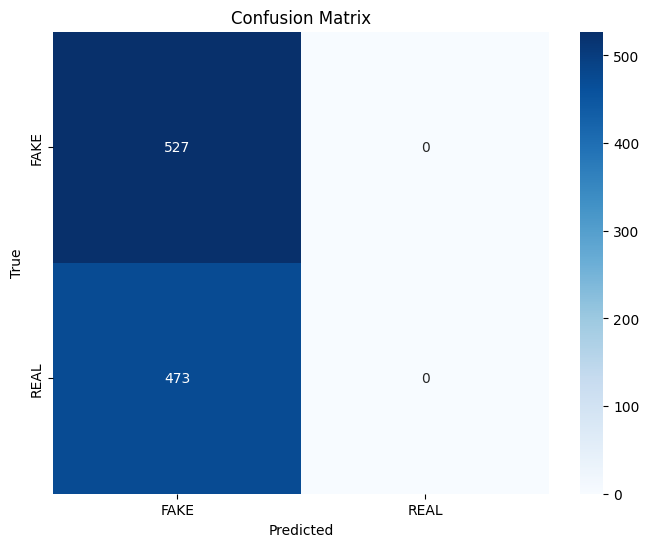

Model evaluation complete.


In [39]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the model to evaluation mode
alexnet_model.eval()

# Lists to store true and predicted labels
all_labels = []
all_predictions = []

print("Starting model evaluation on the test set...")

# No gradient calculation during evaluation
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = alexnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate Accuracy
accuracy = accuracy_score(all_labels, all_predictions)
print(f'\nTest Accuracy: {accuracy:.4f}')

# Generate Classification Report
# Use the classes from the original full dataset for correct labels
# The variable `full_train_dataset_original` is an ImageFolder which has the .classes attribute.
class_names = full_train_dataset_original.classes
report = classification_report(all_labels, all_predictions, target_names=class_names, output_dict=False, zero_division=0)
print('\nClassification Report:')
print(report)

# Generate Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print('\nConfusion Matrix:')
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Model evaluation complete.")

Generating Grad-CAM visualizations for sample images...


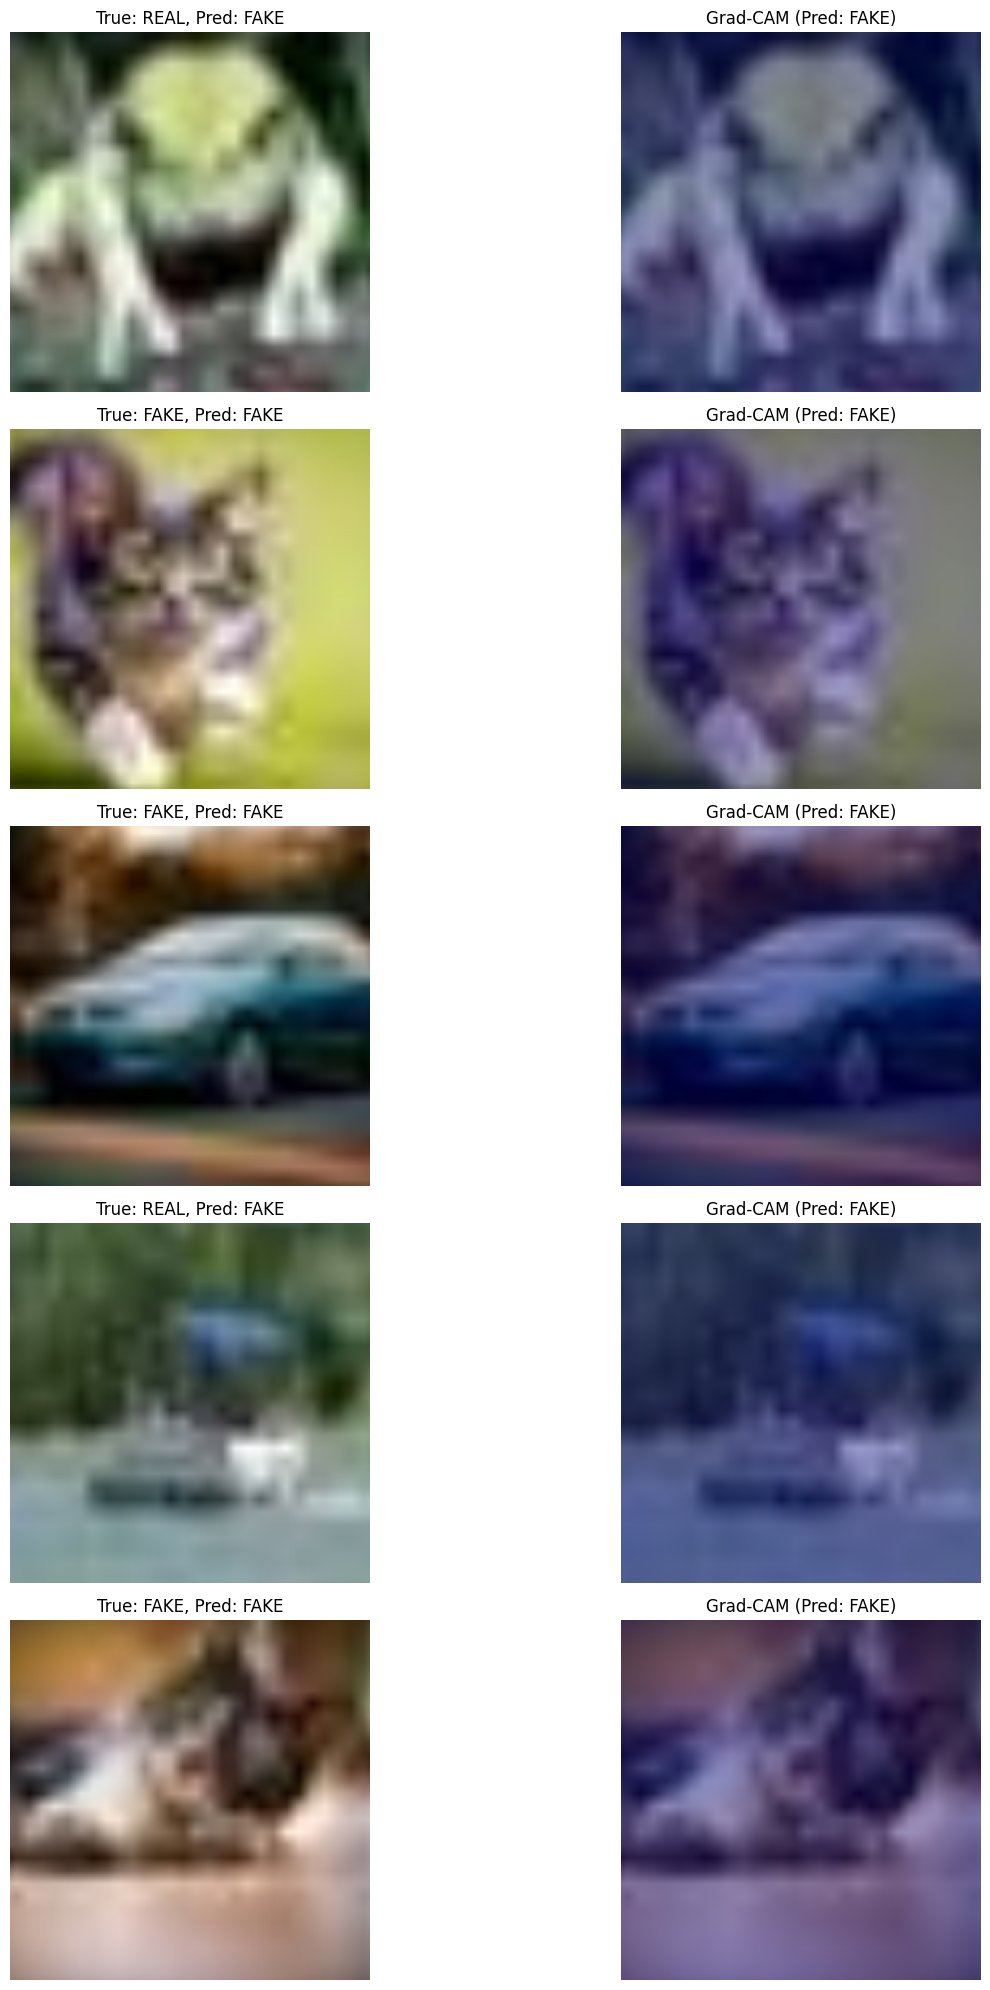

Grad-CAM visualization complete.


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# Ensure the model is in evaluation mode
alexnet_model.eval()

# Modify AlexNet's ReLU layers to be non-in-place
# This is crucial for Grad-CAM to avoid 'RuntimeError: Output 0 of BackwardHookFunctionBackward is a view'
for module in alexnet_model.features.modules():
    if isinstance(module, torch.nn.ReLU):
        module.inplace = False

# Store feature maps and gradients
feature_maps = None
gradients = None

def hook_fn_forward(module, input, output):
    global feature_maps
    feature_maps = output.cpu() # Store feature maps

def hook_fn_backward(module, grad_input, grad_output):
    global gradients
    # grad_output is a tuple; the gradient for the output of the module is the first element
    gradients = grad_output[0].cpu() # Store gradients

# Define the target layer for AlexNet (the last convolutional layer is usually a good choice)
target_layer = alexnet_model.features[10] # Example: features block, last Conv2d layer

# Register hooks
forward_hook = target_layer.register_forward_hook(hook_fn_forward)
backward_hook = target_layer.register_full_backward_hook(hook_fn_backward)


def generate_grad_cam(model, input_image, target_class_idx):
    model.zero_grad()

    # Make sure to clone input_image for gradient calculation if it's reused
    input_image_for_grad = input_image.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(input_image_for_grad)

    # If the target_class_idx is None, use the predicted class
    if target_class_idx is None:
        target_class_idx = output.argmax(dim=1).item()

    # Backward pass for the target class
    # Create a one-hot vector for the target class
    one_hot_output = torch.zeros_like(output)
    one_hot_output[0][target_class_idx] = 1
    output.backward(gradient=one_hot_output, retain_graph=True)

    # Get feature maps and gradients from global variables
    global feature_maps, gradients
    if feature_maps is None or gradients is None:
        raise RuntimeError("Feature maps or gradients not captured. Check hooks.")

    # Clone feature_maps to avoid in-place modification error for heatmap calculation
    cloned_feature_maps = feature_maps.clone()

    # Average the gradients across spatial dimensions (GAP)
    # The gradients stored in `gradients` are for the output of the `target_layer`
    # `gradients` has shape (N, C, H, W)
    pooled_gradients = torch.mean(gradients, dim=[2, 3]) # Average gradients for each feature map

    # Weight the channels by their corresponding gradients
    # Multiply each feature map by its corresponding gradient weight
    # Ensure dimensions match for broadcasting
    for i in range(cloned_feature_maps.shape[1]):
        cloned_feature_maps[:, i, :, :] *= pooled_gradients[0, i] # pooled_gradients[0, i] is scalar

    # Average the weighted feature maps to get the CAM
    heatmap = torch.mean(cloned_feature_maps, dim=1).squeeze()

    # Apply ReLU to the heatmap to only get positive contributions
    heatmap = F.relu(heatmap)

    # Normalize the heatmap to 0-1
    max_val = torch.max(heatmap)
    if max_val > 0:
        heatmap /= max_val
    else:
        heatmap = torch.zeros_like(heatmap) # Handle case where all values are zero

    return heatmap.detach().numpy()


def denormalize_image(image_tensor, mean, std):
    # Reverse normalization: img = img * std + mean
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    image_tensor = image_tensor.cpu() * std + mean
    # Clip values to [0, 1] range for image display
    image_tensor = torch.clamp(image_tensor, 0, 1)
    return image_tensor.permute(1, 2, 0).numpy() # Convert from C, H, W to H, W, C for matplotlib


print("Generating Grad-CAM visualizations for sample images...")

# Select a few sample images from the test_dataset
sample_indices = random.sample(range(len(test_dataset)), 5) # Get 5 random samples

# Transformations for denormalization (using previously defined mean and std)
# Note: This inv_normalize is not used, denormalize_image function handles it.
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

plt.figure(figsize=(15, len(sample_indices) * 4))

for i, idx in enumerate(sample_indices):
    image_tensor, true_label_idx = test_dataset[idx]
    # Ensure image_tensor requires grad for Grad-CAM calculation
    # input_image_for_grad is used inside generate_grad_cam
    image_tensor_for_grad_cam = image_tensor.unsqueeze(0).to(device)

    # Get model prediction
    with torch.no_grad(): # Use no_grad for the prediction part as we only need the value
        output = alexnet_model(image_tensor_for_grad_cam)
        predicted_label_idx = output.argmax(dim=1).item()

    # Generate Grad-CAM heatmap for the predicted class
    heatmap = generate_grad_cam(alexnet_model, image_tensor_for_grad_cam, predicted_label_idx)

    # Denormalize the original image for display
    original_image_display = denormalize_image(image_tensor.squeeze(0), mean, std)

    # Resize heatmap to original image size
    h, w = original_image_display.shape[:2]
    heatmap_resized = cv2.resize(heatmap, (w, h))

    # Overlay heatmap on original image
    # Convert original image to uint8 for cv2 operations if needed, but here matplotlib handles float [0,1]
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    superimposed_img = (original_image_display * 0.6 + (heatmap_colored.astype(np.float32) / 255) * 0.4)
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Plotting
    plt.subplot(len(sample_indices), 2, 2*i + 1)
    plt.imshow(original_image_display)
    plt.title(f'True: {class_names[true_label_idx]}, Pred: {class_names[predicted_label_idx]}')
    plt.axis('off')

    plt.subplot(len(sample_indices), 2, 2*i + 2)
    plt.imshow(superimposed_img)
    plt.title(f'Grad-CAM (Pred: {class_names[predicted_label_idx]})')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Remove hooks after use to prevent memory leaks or unintended behavior
forward_hook.remove()
backward_hook.remove() # Corrected typo from bac_hook.remove()

print("Grad-CAM visualization complete.")